<a href="https://colab.research.google.com/github/sonalshreya25/DeepLearning/blob/main/Assignment6RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Multivariate Time Series Forecasting

## Step 1: Dataset Selection and Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler

import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Checking for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setting seed for repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensuring deterministic behavior for CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



Using device: cuda:0


In [2]:
# Initialize W&B project
wandb.init(project="RNN", entity="usf-alpha-neurons",config={
    'input_size': 2,  # Number of features (TMAX, RHAV)
    'hidden_size': 64,  # Size of hidden layer in RNN
    'output_size': 1,  # Predicting temperature (TMAX)
    'num_epochs': 10,  # Number of epochs for training
    'learning_rate': 0.001  # Learning rate
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sonalshreya (usf-alpha-neurons) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:


# Load dataset (Weather dataset with temperature and humidity)
# Load the NOAA weather dataset
data = pd.read_csv("/content/USW00014607.csv")


# Display the first few rows of the dataset
print(data.columns)

# Inspect the first few rows of the data to understand its structure
print(data.head())

#data.columns = ['Temperature', 'Humidity']  # Renaming columns for clarity







<ipython-input-3-7123e0c343a5>:3: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91,93,95,97,101,107,109,111,115,117,119,121,123,125,127,129,131,133,135,137,139,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/USW00014607.csv")


Index(['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'PRCP',
       'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES',
       ...
       'WT19', 'WT19_ATTRIBUTES', 'WT21', 'WT21_ATTRIBUTES', 'WT22',
       'WT22_ATTRIBUTES', 'WV03', 'WV03_ATTRIBUTES', 'WV20',
       'WV20_ATTRIBUTES'],
      dtype='object', length=144)
       STATION        DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00014607  1939-01-16  46.87049  -68.01723      188.6   
1  USW00014607  1939-01-17  46.87049  -68.01723      188.6   
2  USW00014607  1939-01-18  46.87049  -68.01723      188.6   
3  USW00014607  1939-01-19  46.87049  -68.01723      188.6   
4  USW00014607  1939-01-20  46.87049  -68.01723      188.6   

                                     NAME  PRCP PRCP_ATTRIBUTES  SNOW  \
0  CARIBOU WEATHER FORECAST OFFICE, ME US   0.0            ,,0,   NaN   
1  CARIBOU WEATHER FORECAST OFFICE, ME US   0.0           T,,0,   NaN   
2  CARIBOU WEATHER FORECAST OFFICE, ME US   0.0           T,,0,   NaN   


<ipython-input-4-70a9e76e957a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DATE'] = pd.to_datetime(data['DATE'])
<ipython-input-4-70a9e76e957a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['TMAX', 'RHAV'], inplace=True)


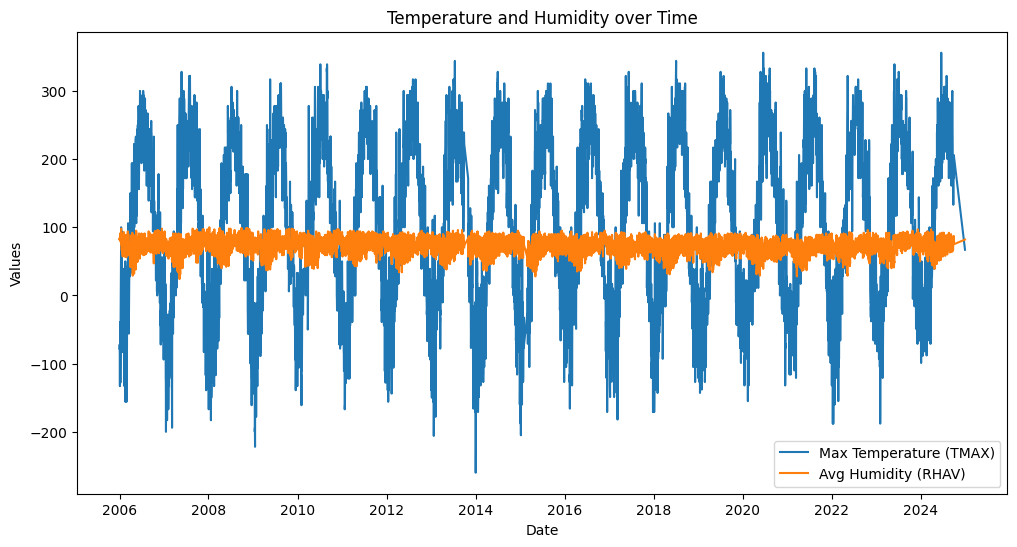

In [4]:
# Select relevant columns (TMAX for temperature, RHAV for humidity)
data = data[['DATE', 'TMAX', 'RHAV']]

# Convert 'DATE' column to datetime type
data['DATE'] = pd.to_datetime(data['DATE'])

# Handle any missing data (you can choose to fill or drop them based on your analysis)
data.dropna(subset=['TMAX', 'RHAV'], inplace=True)

# Visualize the dataset
plt.figure(figsize=(12,6))
plt.plot(data['DATE'], data['TMAX'], label='Max Temperature (TMAX)')
plt.plot(data['DATE'], data['RHAV'], label='Avg Humidity (RHAV)')
plt.title('Temperature and Humidity over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['TMAX', 'RHAV']])

# Function to create sequences for the RNN
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting Temperature (TMAX) only
    return np.array(X), np.array(y)

SEQ_LENGTH = 3
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Convert to PyTorch tensors
import torch
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into train and test sets
split = int(0.8 * len(X))
train_dataset = TensorDataset(X_tensor[:split], y_tensor[:split])
test_dataset = TensorDataset(X_tensor[split:], y_tensor[split:])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
# Access wandb.config as a dictionary
config = wandb.config

# Assign hyperparameters using dictionary keys
input_size = config['input_size']
hidden_size = config['hidden_size']
output_size = config['output_size']
num_epochs = config['num_epochs']
learning_rate = config['learning_rate']

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last output in the sequence
        return out

# Initialize the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
epochs = []

# Training loop with W&B logging
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))  # Ensure targets have correct shape
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Log training metrics to W&B
    train_losses.append(train_loss)
    epochs.append(epoch + 1)
    wandb.log({'train_loss': train_loss, 'epoch': epoch + 1})

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

Epoch [10/10], Loss: 0.0050


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# After training, evaluate the model and log metrics
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        y_pred.extend(outputs.numpy())
        y_true.extend(targets.numpy())

# Convert predictions and targets to numpy arrays
y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# Log evaluation metrics to W&B
wandb.log({'mse': mse, 'mae': mae})

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Visualize predictions vs true values
plt.figure(figsize=(12,6))
plt.plot(range(len(y_true)), y_true, label='True Temperature')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Temperature')
plt.title('True vs Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (TMAX)')
plt.legend()

# Log the plot to W&B
wandb.log({"predictions_vs_true_plot": plt})

# Save the model locally first
torch.save(model.state_dict(), 'model.pth')

# Save the model as an artifact in W&B
artifact = wandb.Artifact('temperature-forecasting-model', type='model')
artifact.add_file('model.pth')  # Now it should find the file

# Log the artifact to W&B
wandb.log_artifact(artifact)





Mean Squared Error (MSE): 0.0057
Mean Absolute Error (MAE): 0.0582


/usr/local/lib/python3.11/dist-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



<Artifact temperature-forecasting-model>

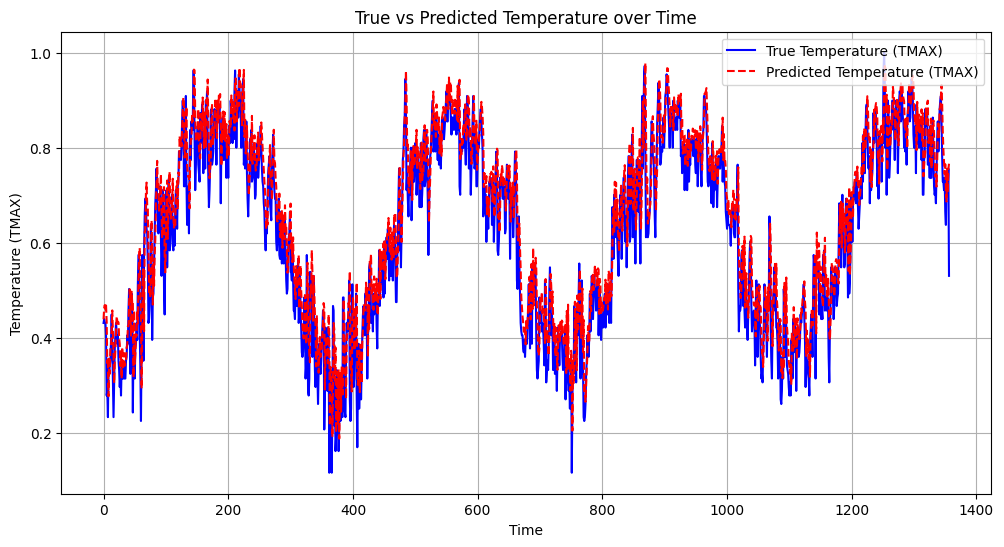

In [7]:
# Plot: True vs Predicted Temperature
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True Temperature (TMAX)', color='blue')
plt.plot(y_pred, label='Predicted Temperature (TMAX)', color='red', linestyle='--')
plt.title('True vs Predicted Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (TMAX)')
plt.legend(loc='upper right')
plt.grid(True)

# Save the plot to a file
plot_filename = 'true_vs_predicted_plot.png'
plt.savefig(plot_filename)

# Log the image file to W&B
wandb.log({"true_vs_predicted_plot": wandb.Image(plot_filename)})

# Optionally display the plot
plt.show()



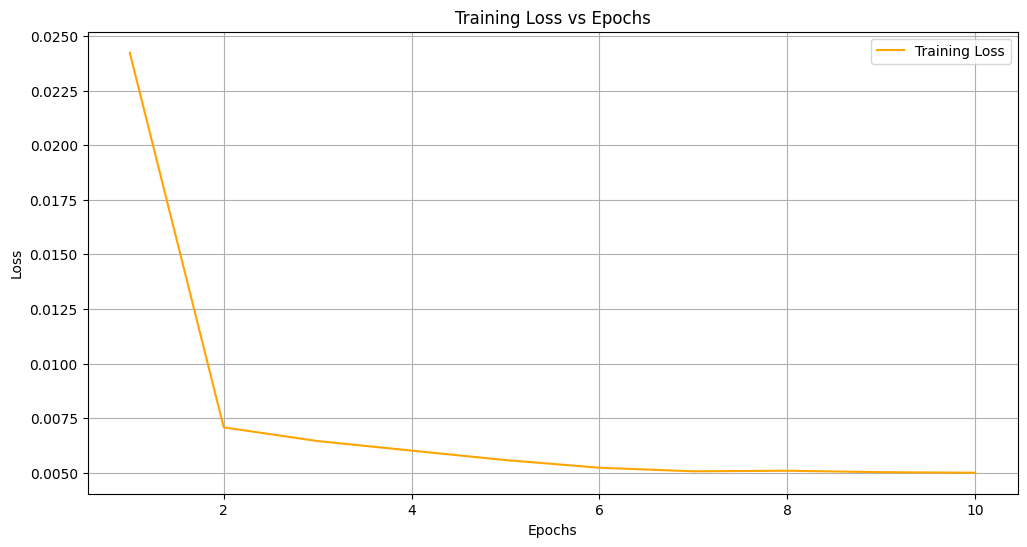

In [9]:
# Plot: Loss vs Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='orange')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Save the plot to a file
loss_plot_filename = 'loss_vs_epoch_plot.png'
plt.savefig(loss_plot_filename)

# Log the image file to W&B
wandb.log({"loss_vs_epoch_plot": wandb.Image(loss_plot_filename)})

# Optionally display the plot
plt.show()


In [10]:
# Finish the W&B run
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
mae,▁
mse,▁
train_loss,█▂▂▁▁▁▁▁▁▁
epoch,10
mae,0.0582
mse,0.0057
train_loss,0.005
